Calculated image dimensions: width=1019, height=1185


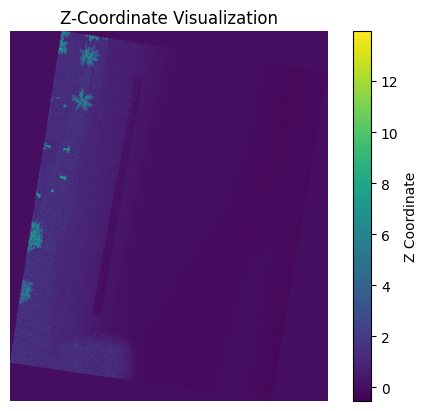

In [1]:
import laspy
import numpy as np
import matplotlib.pyplot as plt

# Load the .las file
file_path = 'Prachuap_SamRoiYot_20230204.las'
las = laspy.read(file_path)

# Extract point coordinates and color information
x = las.x
y = las.y
z = las.z
r = las.red
g = las.green
b = las.blue

# Sort points based on x and y coordinates
sorted_indices = np.lexsort((y, x))
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]
z_sorted = z[sorted_indices]
r_sorted = r[sorted_indices]
g_sorted = g[sorted_indices]
b_sorted = b[sorted_indices]

# Define desired resolution in pixels per unit
resolution = 100# 60 pixels per unit (e.g., 60 pixels per meter)

# Determine the range of x and y coordinates
x_min, x_max = np.min(x_sorted), np.max(x_sorted)
y_min, y_max = np.min(y_sorted), np.max(y_sorted)

# Calculate the width and height of the image based on the resolution
x_range = x_max - x_min
y_range = y_max - y_min
aspect_ratio = y_range / x_range

image_width = int(np.sqrt(resolution * x_range * y_range / aspect_ratio))
image_height = int(aspect_ratio * image_width)

print(f"Calculated image dimensions: width={image_width}, height={image_height}")

# Normalize and scale coordinates to fit the image dimensions
x_scaled = ((x_sorted - x_min) / x_range * (image_width - 1)).astype(np.int32)
y_scaled = ((y_sorted - y_min) / y_range * (image_height - 1)).astype(np.int32)

# Initialize the image array
image = np.zeros((image_height, image_width), dtype=np.float32)
lookupImage = np.zeros((image_height, image_width, 6), dtype=np.float32)

# Populate the image array with z-coordinates
for i in range(len(x_scaled)):
    xi = x_scaled[i]
    yi = y_scaled[i]
    zi = z_sorted[i]
    image[yi, xi] = zi
    lookupImage[yi, xi] = np.array([x_sorted[i], y_sorted[i], z_sorted[i], r_sorted[i], g_sorted[i], b_sorted[i]])

# Display the image
plt.imshow(image, cmap='viridis')
plt.title('Z-Coordinate Visualization')
plt.colorbar(label='Z Coordinate')
plt.axis('off')
plt.show()


0.03 and 0.01

In [2]:
import numpy as np
import cv2

def max_pooling_with_mask(image,lookupImage, threshold,pool_size):
    # Extract dimensions
    h, w = image.shape
    ph, pw = pool_size
    
    newPointClound = []
    
    # Initialize the output
    pooled_image = np.zeros((h, w))
    
    # Pad the image to handle borders
    padded_image = np.pad(image, ((ph//2, ph//2), (pw//2, pw//2)), mode='constant', constant_values=(np.min(image)))
    
    # Initialize the mask
    mask = np.zeros_like(image, dtype=np.uint8)
    
    
    for i in range(h):
        for j in range(w):
            # Extract the region
            region = padded_image[i:i + ph, j:j + pw]
            f0 = padded_image[i + ph // 2, j + pw // 2]
            
            mean = (np.sum(region) - f0)/(ph*pw-1)
                    
            # Apply the transformation (in this case, square of the difference)
            transformed_value = np.square(mean - f0)
            
            # Create the mask based on threshold
            if transformed_value < threshold and f0 != 0:
                mask[i, j] = 255
                newPointClound.append(lookupImage[i,j])
    
    return pooled_image, mask, newPointClound

# Define a threshold value
threshold =0.01

# Apply 3x3 max pooling with same output dimensions
pooled_image, mask,newPointClound = max_pooling_with_mask(image, lookupImage,threshold,pool_size=(10, 10))


print(mask)
np.save("mask.npy",mask)

# Segment the image using the mask
segmented_image = np.zeros_like(image, dtype=np.float32)
segmented_image[mask == 255] = image[mask == 255]

# Save the filtered image and mask
cv2.imwrite('filtered_image.png', pooled_image)
cv2.imwrite('mask.png', mask)
cv2.imwrite('segmented_image.png', segmented_image)

print("Filtered image, mask, and segmented image saved.")

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Filtered image, mask, and segmented image saved.


In [3]:
newPointClound

[array([6.059762e+05, 1.355830e+06, 2.112000e+00, 1.228800e+04,
        1.331200e+04, 1.356800e+04], dtype=float32),
 array([6.0597569e+05, 1.3558301e+06, 2.1300001e+00, 1.1520000e+04,
        1.3824000e+04, 1.0496000e+04], dtype=float32),
 array([6.0597800e+05, 1.3558304e+06, 2.0869999e+00, 1.7664000e+04,
        2.0992000e+04, 2.5088000e+04], dtype=float32),
 array([6.0597806e+05, 1.3558304e+06, 2.0599999e+00, 1.6384000e+04,
        1.9968000e+04, 2.2528000e+04], dtype=float32),
 array([6.0597819e+05, 1.3558305e+06, 2.0650001e+00, 1.9712000e+04,
        2.2528000e+04, 2.5600000e+04], dtype=float32),
 array([6.0597838e+05, 1.3558312e+06, 2.0699999e+00, 3.2768000e+04,
        3.2512000e+04, 3.2000000e+04], dtype=float32),
 array([6.0598319e+05, 1.3558312e+06, 2.0320001e+00, 2.5088000e+04,
        2.6368000e+04, 2.0736000e+04], dtype=float32),
 array([6.0598431e+05, 1.3558312e+06, 2.0220001e+00, 2.3040000e+04,
        2.5600000e+04, 1.8944000e+04], dtype=float32),
 array([6.0597825e+05,

In [4]:
np.array([i[0] for i in newPointClound])

array([605976.2 , 605975.7 , 605978.  , ..., 606042.1 , 606042.56,
       606042.56], dtype=float32)

In [5]:
import numpy as np
import laspy
from laspy.file import File

# Example data
x = np.array([i[0] for i in newPointClound])
y = np.array([i[1] for i in newPointClound])
z = np.array([i[2] for i in newPointClound])
red = np.array([i[3] for i in newPointClound], dtype=np.uint16)  # laspy uses uint16 for colors
green = np.array([i[4] for i in newPointClound], dtype=np.uint16)
blue = np.array([i[5] for i in newPointClound], dtype=np.uint16)

# Create a header for the LAS file
header = laspy.LasHeader(point_format=3)  # Using point format 3 for color

# Set scale and offset
header.offsets = [0, 0, 0]
header.scales = [0.01, 0.01, 0.01]

# Create a new LAS file
las = laspy.LasData(header)

# Assign points
las.X = (x / header.scales[0]).astype(np.int32)
las.Y = (y / header.scales[1]).astype(np.int32)
las.Z = (z / header.scales[2]).astype(np.int32)
las.red = red
las.green = green
las.blue = blue

# Write the LAS file
las.write("output.las")




